In [1]:
# =============================================================================
# 🔍 Model Deteksi Anomali dengan Random Forest
# =============================================================================
# JENIS ANOMALI dalam Model ini
# - `category_mismatch`: Kategori Expense yang dijadikan Income
# - `amount_outlier`: Jumlah transaksi melebihi batas yang ditentukan
# - `time_pattern`: Transaksi di waktu yang tidak wajar
# =============================================================================

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# =============================================================================
# 1. Load Data dari Dataset Baru (Sep 2025 - Jan 2026)
# =============================================================================

# Load dataset baru
with open('/content/kandang_anomaly_dataset_sep2025_jan2026.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['transactions'])

print(f"📊 Total transaksi: {len(df):,}")
print(f"🏠 Total farm: {len(data['farm_ids'])}")
print(f"📅 Rentang tanggal: {data['date_range']['start']} - {data['date_range']['end']}")
print(f"\n🚨 Distribusi Anomali:")
print(df['is_anomaly'].value_counts())

print(f"\n📂 Kategori yang tersedia:")
print(df['category'].unique())

if 'anomaly_type' in df.columns:
    print(f"\n🔍 Tipe Anomali:")
    print(df['anomaly_type'].value_counts())

print("\n📋 Sample data:")
print(df.head())

📊 Total transaksi: 1,500
🏠 Total farm: 3
📅 Rentang tanggal: 2025-09-01 - 2026-01-31

🚨 Distribusi Anomali:
is_anomaly
0    1346
1     154
Name: count, dtype: int64

📂 Kategori yang tersedia:
['Investasi' 'Lainnya' 'Pembangunan' 'Gaji Karyawan' 'Pullet/DOC'
 'Listrik' 'Bunga Bank' 'Obat & Vaksin' 'Transportasi' 'Penjualan Ayam'
 'Lain-lain' 'Pakan' 'Gas Elpiji' 'Penjualan Telur' 'Admin Bank'
 'Peralatan']

🔍 Tipe Anomali:
anomaly_type
category_mismatch    48
duplicate            37
time_pattern         37
amount_outlier       32
Name: count, dtype: int64

📋 Sample data:
          id   farm_id              description       amount     type  \
0  TXN_00184  KANDANG2      Transaksi Investasi  125656443.0   income   
1  TXN_00903  KANDANG3        Transaksi Lainnya    2891782.0   income   
2  TXN_00244  KANDANG3    Transaksi Pembangunan   64588058.0  expense   
3  TXN_01063  KANDANG1    Transaksi Pembangunan   57611519.0  expense   
4  TXN_00491  KANDANG2  Transaksi Gaji Karyawan   15912760.

In [4]:
# =============================================================================
# 2. Feature Engineering
# =============================================================================

def create_features(df, threshold_config=None):
    """
    Bikin fitur-fitur buat model Random Forest
    """
    df_feat = df.copy()

    # 1. AMOUNT FEATURES
    df_feat['amount_log'] = np.log1p(df_feat['amount'])

    # Z-score per category
    df_feat['amount_zscore_category'] = df_feat.groupby('category')['amount'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-10)
    )

    # Z-score per farm
    df_feat['amount_zscore_farm'] = df_feat.groupby('farm_id')['amount'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-10)
    )

    # Amount relative to category median
    df_feat['amount_to_category_median'] = df_feat.groupby('category')['amount'].transform(
        lambda x: x / (x.median() + 1e-10)
    )

    # 2. CATEGORY-TYPE MISMATCH
    # Kategori yang seharusnya expense
    expense_categories = [
        'Pakan', 'Obat & Vaksin', 'Gas Elpiji', 'Peralatan', 'Transportasi',
        'Admin Bank', 'Pembangunan', 'Pullet/DOC', 'Listrik', 'Gaji Karyawan', 'Lainnya'
    ]
    # Kategori yang seharusnya income
    income_categories = [
        'Penjualan Telur', 'Penjualan Ayam', 'Bunga Bank', 'Investasi', 'Lainnya'
    ]

    df_feat['is_expense_category'] = df_feat['category'].isin(expense_categories).astype(int)
    df_feat['is_income_category'] = df_feat['category'].isin(income_categories).astype(int)
    df_feat['type_numeric'] = (df_feat['type'] == 'income').astype(int)

    # Mismatch: kategori expense tapi tipe income, atau sebaliknya
    df_feat['category_type_mismatch'] = (
        ((df_feat['is_expense_category'] == 1) & (df_feat['type_numeric'] == 1)) |
        ((df_feat['is_income_category'] == 1) & (df_feat['type_numeric'] == 0))
    ).astype(int)

    # 3. TIME FEATURES
    df_feat['date_dt'] = pd.to_datetime(df_feat['date'], unit='ms')
    df_feat['day_of_week'] = df_feat['date_dt'].dt.dayofweek
    df_feat['day_of_month'] = df_feat['date_dt'].dt.day
    df_feat['hour_of_day'] = df_feat['date_dt'].dt.hour  # Untuk deteksi waktu tidak wajar
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    df_feat['is_month_end'] = (df_feat['day_of_month'] >= 25).astype(int)
    df_feat['is_night_time'] = ((df_feat['hour_of_day'] >= 22) | (df_feat['hour_of_day'] <= 5)).astype(int)
    df_feat['month'] = df_feat['date_dt'].dt.month  # NEW

    # 4. FREQUENCY FEATURES
    category_freq = df_feat['category'].value_counts(normalize=True)
    df_feat['category_frequency'] = df_feat['category'].map(category_freq)

    df_feat['date_only'] = df_feat['date_dt'].dt.date
    daily_trans = df_feat.groupby(['farm_id', 'date_only']).size().reset_index(name='daily_transaction_count')
    df_feat = df_feat.merge(daily_trans, on=['farm_id', 'date_only'], how='left')

    # 5. DUPLICATE DETECTION
    df_feat['duplicate_key'] = df_feat['farm_id'] + '_' + df_feat['category'] + '_' + df_feat['amount'].astype(str) + '_' + df_feat['date'].astype(str)
    duplicate_counts = df_feat['duplicate_key'].value_counts()
    df_feat['duplicate_count'] = df_feat['duplicate_key'].map(duplicate_counts)
    df_feat['is_potential_duplicate'] = (df_feat['duplicate_count'] > 1).astype(int)

    # 6. THRESHOLD TIDAK WAJAR
    if threshold_config:
        df_feat['exceeds_threshold'] = df_feat.apply(
            lambda row: 1 if row['category'] in threshold_config and row['amount'] > threshold_config[row['category']] else 0,
            axis=1
        )
    else:
        df_feat['exceeds_threshold'] = 0

    # 7. ENCODE CATEGORICAL
    le_category = LabelEncoder()
    le_farm = LabelEncoder()
    le_type = LabelEncoder()

    df_feat['category_encoded'] = le_category.fit_transform(df_feat['category'])
    df_feat['farm_encoded'] = le_farm.fit_transform(df_feat['farm_id'])
    df_feat['type_encoded'] = le_type.fit_transform(df_feat['type'])

    return df_feat, le_category, le_farm, le_type

# Ambil threshold dari config dataset
threshold_config = data.get('anomaly_thresholds', {})
df_features, le_category, le_farm, le_type = create_features(df, threshold_config)
print("✅ Feature engineering selesai!")
print(f"Total features: {len(df_features.columns)}")

✅ Feature engineering selesai!
Total features: 36


In [5]:
# =============================================================================
# 3. Training Random Forest
# =============================================================================

# Kriteria anomali yang dipakai
feature_columns = [
    'amount_log',
    'amount_zscore_category',
    'amount_zscore_farm',
    'amount_to_category_median',
    'category_type_mismatch',
    'is_weekend',
    'is_month_end',
    'is_night_time',
    'category_frequency',
    'daily_transaction_count',
    'is_potential_duplicate',
    'exceeds_threshold',
    'category_encoded',
    'farm_encoded',
    'type_encoded',
    'day_of_week',
    'day_of_month',
    'hour_of_day',
    'month'
]

X = df_features[feature_columns].values
y = df_features['is_anomaly'].values
X = np.nan_to_num(X, nan=0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📊 Training set: {len(X_train):,} samples")
print(f"📊 Test set: {len(X_test):,} samples")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print("\n🌲 Random Forest Classifier")
print("=" * 50)
print(f"\nAccuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"\n📊 Classification Report:")
print(classification_report(y_test, rf_pred, target_names=['Normal', 'Anomaly']))

📊 Training set: 1,200 samples
📊 Test set: 300 samples

🌲 Random Forest Classifier

Accuracy: 0.9567

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       269
     Anomaly       0.95      0.61      0.75        31

    accuracy                           0.96       300
   macro avg       0.95      0.80      0.86       300
weighted avg       0.96      0.96      0.95       300



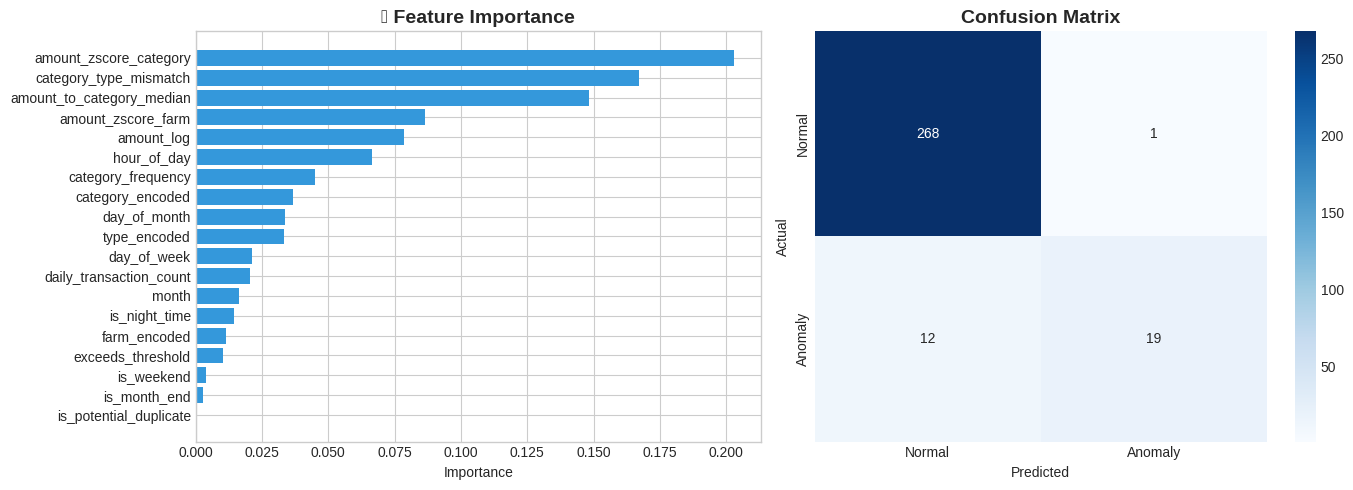

In [7]:
# =============================================================================
# 4. Visualisasi
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature Importance
ax1 = axes[0]
importance = pd.DataFrame({'feature': feature_columns, 'importance': rf_model.feature_importances_})
importance = importance.sort_values('importance', ascending=True)
ax1.barh(importance['feature'], importance['importance'], color='#3498db')
ax1.set_xlabel('Importance')
ax1.set_title('🔑 Feature Importance', fontsize=14, fontweight='bold')

# Confusion Matrix
ax2 = axes[1]
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('model_evaluation_updated.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# =============================================================================
# 5. Save Model untuk Production API
# =============================================================================

import joblib
import os

# Buat folder models
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save model dan artifacts
joblib.dump(rf_model, f'{model_dir}/anomaly_detector_rf.joblib')
joblib.dump(scaler, f'{model_dir}/scaler.joblib')
joblib.dump(le_category, f'{model_dir}/le_category.joblib')
joblib.dump(le_farm, f'{model_dir}/le_farm.joblib')
joblib.dump(le_type, f'{model_dir}/le_type.joblib')

# Save feature columns dan category mappings - Updated
model_config = {
    'feature_columns': feature_columns,
    'expense_categories': [
        'Pakan', 'Obat & Vaksin', 'Gas Elpiji', 'Peralatan', 'Transportasi',
        'Admin Bank', 'Pembangunan', 'Pullet/DOC', 'Listrik', 'Gaji Karyawan', 'Lain-lain'
    ],
    'income_categories': [
        'Penjualan Telur', 'Penjualan Ayam', 'Bunga Bank', 'Investasi', 'Lainnya'
    ],
    'anomaly_thresholds': threshold_config,
    'category_mapping': dict(zip(le_category.classes_, range(len(le_category.classes_)))),
    'type_mapping': {'expense': 0, 'income': 1},
    'date_range': data['date_range'],
    'farm_ids': data['farm_ids']
}

with open(f'{model_dir}/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("✅ Model tersimpan di folder 'models/'")
print(f"\n📁 Files:")
for file in os.listdir(model_dir):
    print(f"  - {file}")


✅ Model tersimpan di folder 'models/'

📁 Files:
  - model_config.json
  - le_category.joblib
  - scaler.joblib
  - le_farm.joblib
  - anomaly_detector_rf.joblib
  - le_type.joblib


In [9]:
# =============================================================================
# 6. Test Prediksi Sample (NEW)
# =============================================================================

print("\n" + "=" * 50)
print("🧪 Test Prediksi Sample")
print("=" * 50)

# Ambil beberapa sample anomali
sample_anomalies = df[df['is_anomaly'] == 1].head(3)
for idx, row in sample_anomalies.iterrows():
    print(f"\n📌 Transaksi: {row.get('id', idx)}")
    print(f"   Kategori: {row['category']}")
    print(f"   Amount: Rp {row['amount']:,.0f}")
    print(f"   Type: {row['type']}")
    print(f"   Date: {row.get('date_readable', 'N/A')}")
    print(f"   Anomaly Type: {row.get('anomaly_type', 'N/A')}")



🧪 Test Prediksi Sample

📌 Transaksi: TXN_01003
   Kategori: Listrik
   Amount: Rp 4,504,063
   Type: income
   Date: 2025-09-03 20:30:34
   Anomaly Type: category_mismatch

📌 Transaksi: TXN_01084
   Kategori: Penjualan Telur
   Amount: Rp 7,419,625
   Type: expense
   Date: 2025-09-04 17:18:38
   Anomaly Type: category_mismatch

📌 Transaksi: TXN_00519
   Kategori: Gas Elpiji
   Amount: Rp 1,160,154
   Type: expense
   Date: 2025-09-05 07:42:23
   Anomaly Type: duplicate
